# 분석프로그래밍 팀프로젝트
- 조원: 김찬영, 나요셉, 하서경

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D # 3차원 시각화
import seaborn as sns

import arrow
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [2]:
cs = pd.read_csv('Demo.csv', encoding='cp949')
tr = pd.read_csv('구매내역정보.csv', encoding='cp949')
df_raw = cs.merge(tr, on='ID')

## Data Cleansing

**[dtype 변경]**

In [3]:
# 구매일자 dtype 변경 
df_raw['구매일자'] = pd.to_datetime(df_raw['구매일자'], format='%Y%m%d')

**[column 변경]**

In [4]:
# 성별 변경
df_raw['성별'] = df_raw['성별'].apply(lambda x: '남성' if x==1 else "여성")

**[데이터 삭제 및 변경]**

- 구매수량은 있으나 구매금액은 0이라 서로 의미하는 바가 다른 데이터를 처리한다.
  - 취소여부가 1로 환불된 데이터의 경우 추후 일괄적으로 제거한다. 
  - 해당 고객이 같은 날 동일한 상품중분류명의 상품을 2배 이상 산 경우 
    <br>1+1 행사 상품을 구매하여 증정되는 상품이 구매수량은 인식되었으나 구매금액은 인식되지 않은 경우로 보고 
    <br>추후 고객 분석에 사용하기 위해 따로 저장해둔 뒤 제거한다.
  - 환불데이터와 1+1 이외의 데이터는 모두 제거한다.

In [5]:
# 잘못된 데이터 확인
print('구매금액과 구매수량이 모두 0인경우:', df_raw.query('구매금액 == 0 and 구매수량 == 0').shape[0])
print('구매금액은 있는데 구매수량이 0인경우:', df_raw.query('구매금액 != 0 and 구매수량 == 0').shape[0])
print('구매수량은 있는데 구매금액이 0인경우:', df_raw.query('구매금액 == 0 and 구매수량 != 0').shape[0])

구매금액과 구매수량이 모두 0인경우: 0
구매금액은 있는데 구매수량이 0인경우: 0
구매수량은 있는데 구매금액이 0인경우: 200


In [6]:
dc = df_raw.query('구매금액 == 0 and 구매수량 != 0')

In [7]:
## 환불 데이터로 추후 제거
dc.query('취소여부==1').shape[0]

6

In [8]:
## 1 + 1 행사 상품
bogo = list()

for index, ID, gm, day, count in dc.query('취소여부==0')[["ID", "상품중분류명", "구매일자", '구매수량']].itertuples():
    data = df_raw.query('ID == @ID and 상품중분류명 == @gm and 구매일자 == @day')
    if data['구매수량'].sum() >= 2*count:
        bogo.append(index)
        
df_raw.loc[bogo].to_csv('bogo.csv', encoding='cp949', index=False) # 1+1 구매 고객, 상품중분류명

In [9]:
## 1 + 1 행사 상품 데이터와 그 외 데이터 삭제
df_raw.drop(bogo+dc.query('취소여부==0').index.tolist(), inplace=True)

In [10]:
## 환불 데이터를 제외한 나머지 데이터는 모두 제거되었다.
df_raw.query('구매금액 == 0 and 구매수량 != 0').shape[0]

6

- 환불데이터는 구매력이 없음으로 제거한다.
  - 해당 고객의 환불일자 이전의 구매데이터에 동일한 상품중분류명 중 단가가 동일한 데이터가 없는 경우 
    <br>이전 해의 구매데이터로 보고 환불데이터만 제거한다.
  - 해당 고객의 환불일자 이전의 구매데이터에 동일한 상품중분류명 중 단가가 동일하며 구매수량이 환불수량 이상인 데이터가 존재할 경우
    <br>해당 구매데이터를 제거하거나 환불수량과 환불금액을 감안하여 구매데이터를 수정한 후 환불데이터를 제거한다.

In [11]:
# 식제할 환불데이터 확인
df_raw.query('취소여부==1').shape[0]

8359

In [12]:
## 수정할 DataFrame
df_erase = df_raw.copy()
df_csv = df_raw.copy()

In [13]:
## 구매데이터 삭제 및 수정
df_refund = df_raw.query('취소여부==1')[['ID', '상품중분류명', '구매일자', '구매수량', '구매금액']]
past = []

for index, ID, gm, day, count, p in df_refund.itertuples():
    data = df_erase.query('ID==@ID and 상품중분류명==@gm and 구매일자<=@day and 구매수량>=abs(@count) and 구매금액>=abs(@p)')\
           .sort_values(by='구매일자', ascending=False)
    data = data[data['구매금액']/data['구매수량'] == p/count][['구매수량', '구매금액']]
    if data.shape[0] == 0:
        past.append(index) ## 2014년 이전에 구매한 상품을 환불한 데이터
    else:
        for index_, count_, p_ in data.itertuples():
            if count+count_==0 and p+p_==0:
                df_raw.drop(index_, inplace=True)
                df_erase.drop(index_, inplace=True) ## 대응되는 거래데이터 삭제
                break
        else:  ## 대응되는 거레데이터 수정
            df_raw.loc[data.index[:1], '구매수량'] = df_erase.loc[data.index[:1], '구매수량'] + count
            df_raw.loc[data.index[:1], '구매금액'] = df_erase.loc[data.index[:1], '구매금액'] + p 
            df_erase.drop(data.index[:1], inplace=True)
            
df_raw.drop(df_refund.index, inplace=True)  ## 환불데이터 삭제                

In [14]:
## 2014년 이전에 구매한 상품의 환불데이터를 제외한 나머지 데이터로 구한 고객별 총 구매금액은 
## 2014년에 구매한 상품의 환불데이터를 처리한 데이터로 구한 고객별 총 구매금액과 같다.
original = df_csv.drop(past).groupby('ID')['구매금액'].agg([('original', sum)]).reset_index()
revision = df_raw.groupby('ID')['구매금액'].agg([('revision', sum)]).reset_index()
confirm = original.merge(revision)
confirm['zero'] = confirm['original'] - confirm['revision']
confirm.query('zero != 0').shape[0]

0

In [15]:
# 잘못된 데이터 모두 수정 완료
print('구매금액과 구매수량이 모두 0인경우:', df_raw.query('구매금액 == 0 and 구매수량 == 0').shape[0])
print('구매금액은 있는데 구매수량이 0인경우:', df_raw.query('구매금액 != 0 and 구매수량 == 0').shape[0])
print('구매수량은 있는데 구매금액이 0인경우:', df_raw.query('구매금액 == 0 and 구매수량 != 0').shape[0])

구매금액과 구매수량이 모두 0인경우: 0
구매금액은 있는데 구매수량이 0인경우: 0
구매수량은 있는데 구매금액이 0인경우: 0


**[column 삭제]**

In [16]:
# 취소여부 column 제거
df_raw.drop('취소여부', inplace=True, axis=1)

**[column 추가]**

In [17]:
# 단가 추가
df_raw['단가'] = df_raw['구매금액']//df_raw['구매수량']

In [18]:
# 구매월 추가
df_raw['구매월'] = df_raw['구매일자'].dt.month
df_raw['구매요일'] = df_raw['구매일자'].dt.weekday

In [19]:
# 동지역 추가
same = []
for i,j in zip(df_raw['거주지역'],df_raw['구매지역']) :
    if i == j :
        same.append(1)
    else :
        same.append(0)

df_raw['동지역'] = same

In [20]:
df_raw.to_csv('clean_data.csv', encoding='cp949', index=False)

## 데이터 기본 정보

In [21]:
Bogo = pd.read_csv('bogo.csv', encoding='cp949')
Bogo['구매일자'] = Bogo['구매일자'].astype('datetime64')

In [22]:
df = pd.read_csv('clean_data.csv', encoding='cp949')
df['구매일자'] = df['구매일자'].astype('datetime64')

In [23]:
man, women = df.drop_duplicates('ID').groupby('성별').size()
print('-----------------df------------------')
print(f'▶ 데이터 개수: {df.shape[0]}')
print(f'▶ 고객수: {df.ID.nunique()}')
print(f'▶ 성별별 고객수: 여성 {women} 남성 {man}')
print(f'▶ 고객 연령: {df.연령.min()} ~ {df.연령.max()}')

man, women = Bogo.drop_duplicates('ID').groupby('성별').size()
print('----------------Bogo-----------------')
print(f'▶ 데이터 개수: {Bogo.shape[0]}')
print(f'▶ 고객수: {Bogo.ID.nunique()}')
print(f'▶ 성별별 고객수: 여성 {women} 남성 {man}')
print(f'▶ 고객 연령: {Bogo.연령.min()} ~ {Bogo.연령.max()}')

-----------------df------------------
▶ 데이터 개수: 86797
▶ 고객수: 3541
▶ 성별별 고객수: 여성 2682 남성 859
▶ 고객 연령: 55 ~ 84
----------------Bogo-----------------
▶ 데이터 개수: 156
▶ 고객수: 132
▶ 성별별 고객수: 여성 102 남성 30
▶ 고객 연령: 55 ~ 83


## 고객 범주화

### ▶ 범주화 기준
&#160;&#160;&#160; 2014.12.31.에서 최근 구매일자를 뺀 경과일인 recency, 2014.01.01. ~ 2014.12.31. 동안 구매한 일자 수인 frequency와 총 구매금액인 monetary를
<br>&#160;&#160;&#160; MinMaxScailing한 후 Kmeans clustering의 기준으로 넣는다.
<br><br>
&#160;&#160;&#160; Kmeans clustering의 기준으로 RFM을 설정하는 분석은 과거에도 이루어졌다. 
<br>&#160;&#160;&#160; https://www.kaggle.com/jnikhilsai/rfm-clustering-of-customers-using-k-means
<br>&#160;&#160;&#160; https://towardsdatascience.com/rfm-clustering-on-credit-card-customers-cdec560281c0

In [24]:
# Recency
# Recency는 작으면 좋음으로 12.31.에서 해당 날짜를 빼는 것이 아닌 해당 날짜에서 12.31.을 빼는 것으로 구한다.
recency = df.groupby('ID')['구매일자'].agg([('recency', lambda x: (x.max() - df.구매일자.max()).days)]).reset_index()

In [25]:
# Frequency
frequency = df.groupby('ID')['구매일자'].agg([('frequency', lambda x: x.nunique())]).reset_index()

In [26]:
# Monetary
monetary= df.groupby('ID')['구매금액'].agg([('monetary', np.sum)]).reset_index()

In [27]:
rfm = pd.merge(recency, frequency).merge(monetary)
rfm.head()

,ID,recency,frequency,monetary
0,741463,-274,6,560000
1,909249,-6,11,640000
2,1065068,-2,5,1103000
3,1310410,-80,2,249000
4,1387032,-30,4,113000


### ▶ VIP, Normal 구분
&#160;&#160;&#160; 마케팅에서 가장 중요한 고객군이 우수고객으로 신세계백화점의 VIP 기준을 사용하여 VIP 고객과 Normal 고객으로 구분한다.

In [28]:
vip = rfm.query('monetary >= 4000000 and frequency >= 24')
normal = rfm.query('ID not in @vip.ID.unique()')

### ▶ Outlier 제외
&#160;&#160;&#160; Kmeans clustering과 MinMaxScaler 모두 outlier에 민감하기에 outlier에 해당하는 데이터는 분석에서 제외한다.

In [29]:
# vip에서 outlier 해당하는 고객 제외
q1, q3  = vip.recency.quantile(q=[0.25, 0.75])
IQR = q3 - q1
low, upper = q1 - IQR, q3 + IQR
vip = vip.query('@low <= recency <= @upper')

q1, q3  = vip.frequency.quantile(q=[0.25, 0.75])
IQR = q3 - q1
low, upper = q1 - IQR, q3 + IQR
vip = vip.query('@low <= frequency <= @upper')

q1, q3  = vip.monetary.quantile(q=[0.25, 0.75])
IQR = q3 - q1
low, upper = q1 - IQR, q3 + IQR
vip = vip.query('@low <= monetary <= @upper')

In [30]:
# normal에서 outlier 해당하는 고객 제외
q1, q3  = normal.recency.quantile(q=[0.25, 0.75])
IQR = q3 - q1
low, upper = q1 - IQR, q3 + IQR
normal = normal.query('@low <= recency <= @upper')

q1, q3  = normal.frequency.quantile(q=[0.25, 0.75])
IQR = q3 - q1
low, upper = q1 - IQR, q3 + IQR
normal = normal.query('@low <= frequency <= @upper')

q1, q3  = normal.monetary.quantile(q=[0.25, 0.75])
IQR = q3 - q1
low, upper = q1 - IQR, q3 + IQR
normal = normal.query('@low <= monetary <= @upper')

### ▶ MinMaxScaler

In [31]:
# MinMaxScaler 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_vip = scaler.fit_transform(vip.iloc[:, 1:]) 
X_normal = scaler.fit_transform(normal.iloc[:, 1:]) 

### ▶ Clustering
&#160;&#160;&#160; 군집별 마케팅을 진행하고자 하여 VIP, Normal고객을 군집으로 나눈다.

- **VIP clustering**

In [32]:
# 군집 수에 따른 SSE(군집내 오차제곱합)
wss = []
sis = []
for k in range(3,8): # 숫자가 작을수록 albow 찾기가 쉬움
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_vip)
    wss = np.append(wss, kmeans.inertia_)

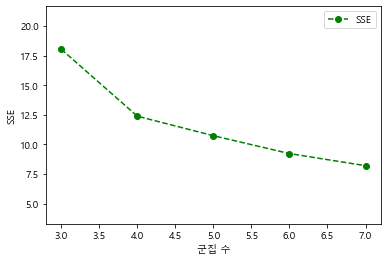

In [33]:
# 군집 수에 따른 SSE 시각화(best k = 4)
fig, ax = plt.subplots()
line = ax.plot(np.arange(3,8), wss, 'go--', label='SSE')
ax.set_ylim(wss.min()*0.4, wss.max()*1.2)
ax.set_xlabel('군집 수')
ax.set_ylabel('SSE')
labels = [l.get_label() for l in line]
plt.legend(line, labels)
plt.show() 

In [34]:
kmeans = KMeans(n_clusters=4, random_state=0, ) 
kmeans.fit(X_vip)

KMeans(n_clusters=4, random_state=0)

In [35]:
vip['segment'] = kmeans.labels_ 

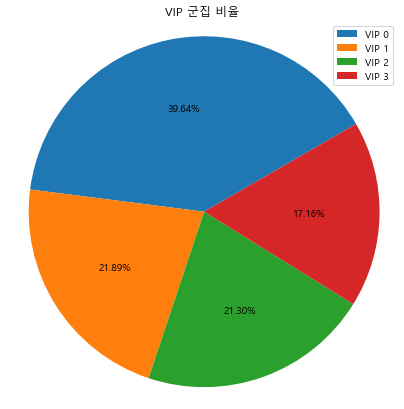

In [36]:
plt.figure(figsize=(7,7))
plt.pie(vip.segment.value_counts(), autopct='%.2f%%', startangle=30)
plt.title("VIP 군집 비율")
plt.axis('equal')
plt.legend(labels=['VIP 0', 'VIP 1', 'VIP 2', 'VIP 3'])
plt.show() 

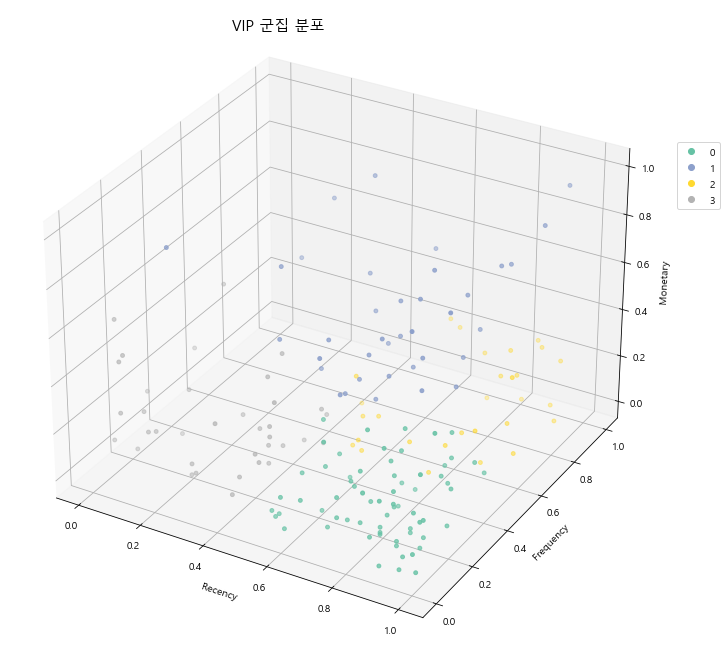

In [37]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
sc = ax.scatter3D(X_vip[:, 0], X_vip[:, 1],X_vip[:, 2], c=vip.segment, marker='o', s=15, cmap='Set2')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.text(-0.15, 1, 1.2, "VIP 군집 분포", fontdict={'fontsize':15})
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.1, 0.8))
plt.show()

- **Normal clustering**

In [38]:
# 군집 수에 따른 SSE(군집내 오차제곱합)
wss = []
sis = []
for k in range(2,8): # 숫자가 작을수록 albow 찾기가 쉬움
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_normal)
    wss = np.append(wss, kmeans.inertia_)

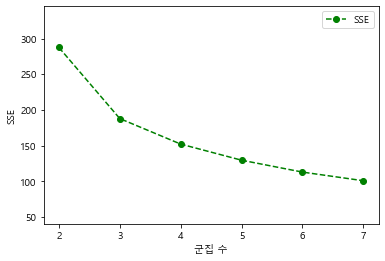

In [39]:
# 군집 수에 따른 SSE 시각화(best k = 3)
fig, ax = plt.subplots()
line = ax.plot(np.arange(2,8), wss, 'go--', label='SSE')
ax.set_ylim(wss.min()*0.4, wss.max()*1.2)
ax.set_xlabel('군집 수')
ax.set_ylabel('SSE')
labels = [l.get_label() for l in line]
plt.legend(line, labels)
plt.show() 

In [40]:
kmeans = KMeans(n_clusters=3, random_state=0, )
kmeans.fit(X_normal)

KMeans(n_clusters=3, random_state=0)

In [41]:
normal['segment'] = kmeans.labels_ 

In [1]:
plt.figure(figsize=(7,7))
plt.pie(normal.segment.value_counts(), autopct='%.2f%%', startangle=30)
plt.title("Normal 군집 비율")
plt.axis('equal')
plt.legend(labels=['Normal 0', 'Normal 1', 'Normal 2'])
plt.show() 

NameError: name 'plt' is not defined

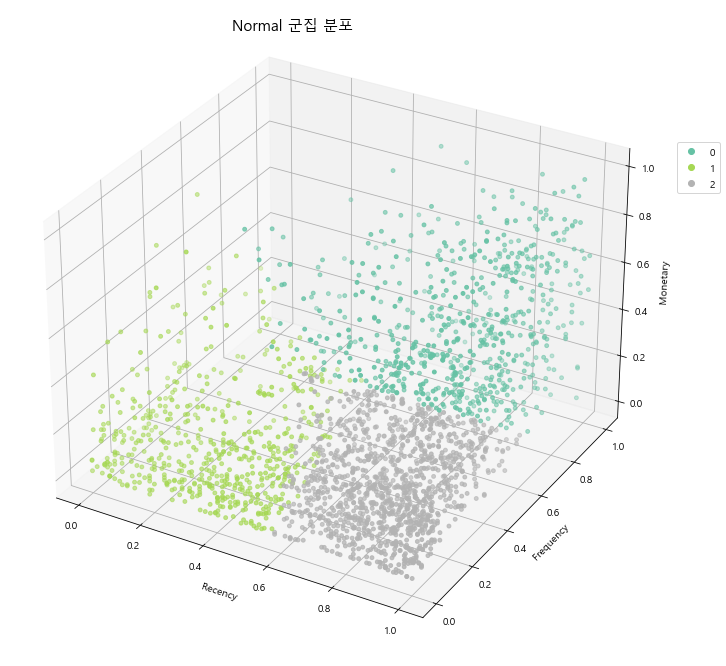

In [43]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
sc = ax.scatter3D(X_normal[:, 0], X_normal[:, 1],X_normal[:, 2], c=normal.segment, marker='o', s=15, cmap='Set2')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.text(-0.15, 1, 1.2, "Normal 군집 분포", fontdict={'fontsize':15})
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.1, 0.80))
plt.show()

## Feature
여러 개의 feature를 제작한 뒤 큰 차이를 보이는 feature만을 사용하여 분석을 시도하고자 한다.
<br>feature는 표준화하여 사용한다.

In [44]:
# 구매금액 feature
# 총구매액
feature =  df.groupby('ID')['구매금액'].agg([('총구매액', sum)])

# 일별구매액
feature['일별구매액'] = df.groupby('ID')['구매금액'].sum().div(df.groupby('ID')['구매일자'].nunique()).astype('int64')

# 고가상품구매율
q1, q3 = df.groupby('ID')['단가'].mean().quantile(q=[0.25, 0.75])
IQR = q3 - q1
feature['고가상품구매율'] = df.groupby('ID')['단가'].agg(lambda x: (x >= (q3 + 1.5 * IQR)).mean().round(2))

# 단가
feature['평균단가'] = df.groupby('ID')['단가'].mean()

In [45]:
# 구매추세
week_start = df.구매일자.max()
week_trans=[]
for i in range(10):
    week_from = week_start + pd.DateOffset(weeks=-1)
    week_trans.append(df.query('@week_from<구매일자<@week_start').groupby('ID')['구매금액'].agg([(f'w{10-i}','count')])
                      .reset_index())
    week_start=week_from
    
trend = pd.DataFrame({'ID' : df.ID.unique()})
for w in week_trans[::-1]:
    trend = pd.merge(trend, w ,how = 'left')
trend = trend.fillna(0)

feature['구매추세'] = trend.apply(lambda x: np.polyfit(range(10), x[1:], 1)[0].round(2), axis=1).values

In [46]:
# 구매일자 feature
feature['내점일자'] = df.groupby('ID')['구매일자'].agg([('내점일자', pd.Series.nunique)])

In [47]:
# 구매수량 feaature
feature['평균구매수'] = df.groupby('ID')['구매수량'].mean()
feature['일별구매수'] = df.groupby('ID')['구매수량'].sum().div(feature.내점일자).astype('int64')

In [48]:
# 상품중분류명 feature
feature['구매다양성'] = df.groupby('ID')['상품중분류명'].nunique()
feature['일별상품수'] = df.groupby('ID')['상품중분류명'].size().div(feature.내점일자).astype('int64')

In [49]:
# 동지역 feature
feature = pd.merge(feature,df.groupby('ID')['동지역'].mean().reset_index(), on = 'ID',how = 'left')

In [50]:
# 1+1 행사 상품 feature
bogo = Bogo.groupby('ID').agg({'구매수량':[('BOGO총구매개수', sum), ('BOGO거래발생수', 'size')],
                               '구매일자':[('BOGO내점일수', pd.Series.nunique)],
                               '상품중분류명':[('BOGO구매다양성', pd.Series.nunique)]})
bogo.columns = bogo.columns.get_level_values(1)
feature = pd.merge(feature, bogo, on = 'ID', how = 'left')

## Cluster별 분석

### ▶ VIP
&#160;&#160;&#160; VIP 0는 최근에 구매했으나 다른 VIP 군집에 비해 구매횟수와 구매금액이 낮은 고객이다.
<br>&#160;&#160;&#160; VIP 1은 최근에 구매했으며 구매금액이 앞도적으로 높으나 구매횟수가 비교적 낮은 대량구매고객이다.
<br>&#160;&#160;&#160; VIP 2는 최근에 구매했으며 자주 구매하나 구매금액은 비교적 낮은 고객이다.
<br>&#160;&#160;&#160; VIP 3는 구매가 최근에 이루어지지 않았으며 구매빈도도 낮으나 구매금액은 비교적 높은 고객이다.

In [51]:
# VIP의 RFM DataFrame 
df_X_vip = pd.DataFrame(X_vip, columns=['Recency', 'Frequency', 'Monetary'])
df_X_vip = pd.concat([df_X_vip, vip.reset_index().segment], axis=1)
df_X_vip.segment = 'VIP '+df_X_vip.segment.astype('str')

<Figure size 432x288 with 0 Axes>

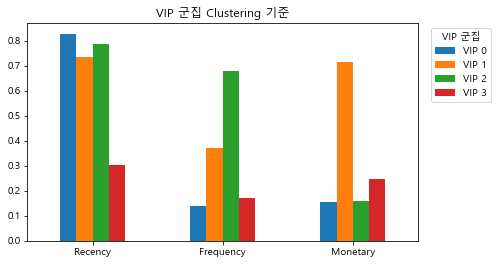

In [52]:
plt.tight_layout(h_pad=5)
df_X_vip.groupby('segment').mean().T.plot.bar(figsize=(7, 4), rot=0, sharey=True)
plt.title("VIP 군집 Clustering 기준")
plt.legend(title="VIP 군집", bbox_to_anchor=(1.2, 1))
plt.show()

In [53]:
# VIP feature
vip_feature = feature.query('ID in @vip.ID')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
vip_feature_data = scaler.fit_transform(vip_feature.iloc[:, 1:]) 
feature_vip = pd.DataFrame(vip_feature_data, columns=vip_feature.columns[1:])
feature_vip = vip.reset_index()[['ID', 'segment']].merge(pd.concat([vip_feature.reset_index()['ID'], feature_vip], axis=1))
feature_vip['segment'] = 'VIP '+ feature_vip['segment'].astype('str')

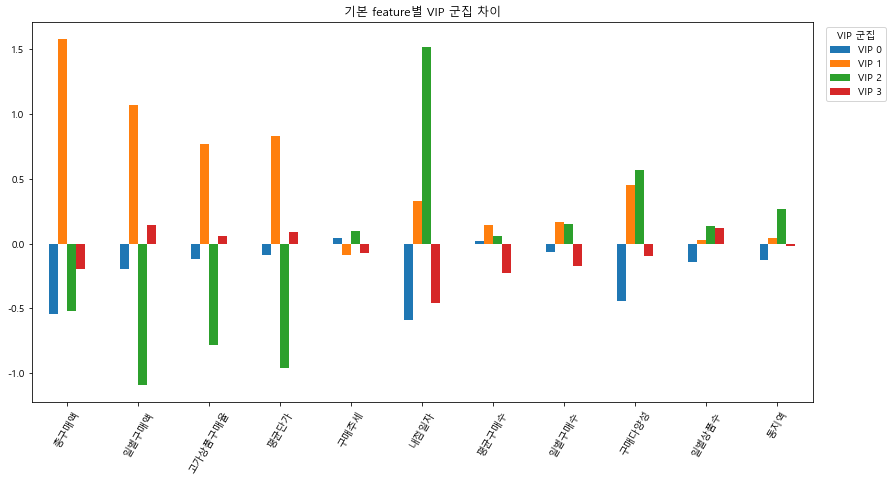

In [54]:
feature_vip.iloc[:, 1:-4].groupby('segment').mean().T.plot.bar(figsize=(14, 7), rot=60, sharey=True)
plt.title("기본 feature별 VIP 군집 차이")
plt.legend(title="VIP 군집", bbox_to_anchor=(1.1, 1))
plt.show()

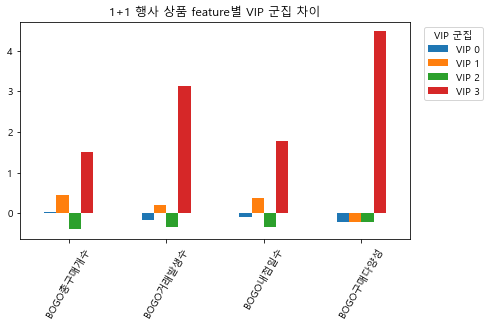

In [55]:
feature_vip.loc[:, ['segment', 'BOGO총구매개수', 'BOGO거래발생수', 'BOGO내점일수', 'BOGO구매다양성' ]]\
.groupby('segment').mean().T.plot.bar(legend=False, figsize=(7, 4), rot=60, sharey=True)
plt.title("1+1 행사 상품 feature별 VIP 군집 차이")
plt.legend(title="VIP 군집", bbox_to_anchor=(1.2, 1))
plt.show()

In [56]:
# VIP 데이터
VIP = df.query('ID in @vip.ID').reset_index().iloc[:, 1:]
VIP = VIP.merge(vip, on='ID')
VIP.segment = 'VIP '+VIP.segment.astype('str')

### *`VIP 0`*
구매빈도와 구매금액을 올려야 하는 고객군집
- 월별 구매고객수와 월별 구매금액으로 scatterplot을 그리고 구매고객수와 구매금액이 모두 높았던 월의 상품중분류명을 분석한다.
- 명품 구매 분포를 파악하여 마케팅 방안을 수립한다.
- 여가활동과 관련한 마케팅 방안을 수립한다.

In [57]:
# 월별 구매한 고객수와 총구매금액
scatter = VIP.drop_duplicates(['ID', '구매일자']).groupby(['segment', '구매월'])['ID'].agg([('월별구매고객수', 'size')])
scatter['월별총구매액'] = VIP.groupby(['segment', '구매월'])['구매금액'].sum()

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scatter_data = scaler.fit_transform(scatter) 
scatter_scaler = pd.DataFrame(scatter_data, columns=['월별구매고객수', '월별총구매액'])
scatter_scaler = scatter_scaler.set_index(scatter.index)

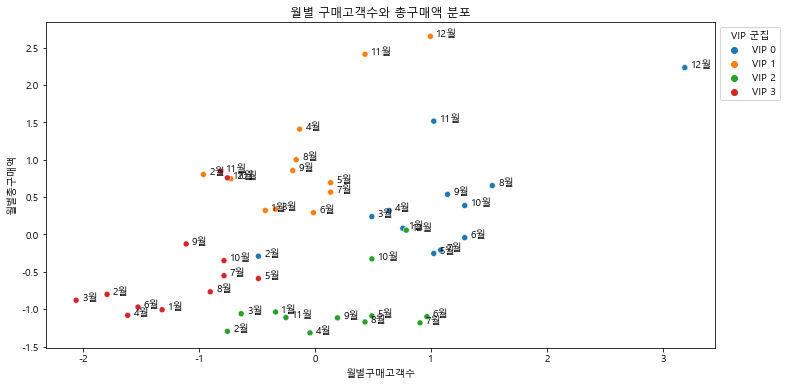

In [59]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scatter_scaler, x='월별구매고객수', y='월별총구매액', hue=scatter_scaler.index.get_level_values(0))
for i in range(scatter_scaler.shape[0]):
    plt.text(scatter_scaler.월별구매고객수.iloc[i]+0.05, scatter_scaler.월별총구매액.iloc[i], 
             str(scatter_scaler.index.get_level_values(1)[i])+'월')
plt.title("월별 구매고객수와 총구매액 분포")
plt.legend(title="VIP 군집", bbox_to_anchor=(1, 1))
plt.show()
plt.show()

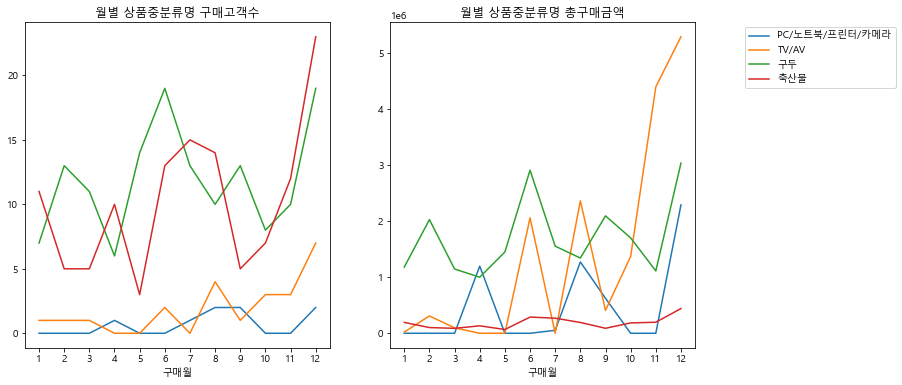

In [60]:
# 월별 상품중분류명
high = ['TV/AV', 'PC/노트북/프린터/카메라', '구두', '축산물']
month_tv = pd.pivot_table(VIP.query('segment=="VIP 0" and 상품중분류명 in @high'), 
                          index='구매월', columns='상품중분류명', values='ID', aggfunc='size', fill_value=0)

month_tp = pd.pivot_table(VIP.query('segment=="VIP 0" and 상품중분류명 in @high'), 
                          index='구매월', columns='상품중분류명', values='구매금액', aggfunc=sum, fill_value=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
month_tv.plot(title="월별 상품중분류명 구매고객수", ax=ax[0], legend=False)
month_tp.plot(title="월별 상품중분류명 총구매금액", ax=ax[1])
ax[0].set_xticks(range(1, 13))
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()

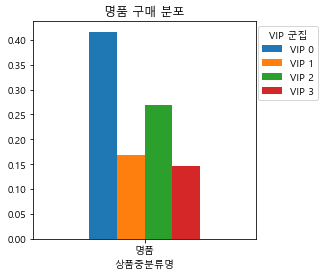

In [61]:
# 명품 구매율이 높음
buy = pd.pivot_table(VIP.query("상품중분류명 == '명품'"), index='segment', columns='상품중분류명', 
                     values='ID', aggfunc='count', fill_value=0, margins=True)
buy = buy.div(buy.loc["All"])

buy.T.iloc[:-1, :-1].plot.bar(figsize=(4, 4), title="명품 구매 분포", rot=0)
plt.legend(title="VIP 군집", bbox_to_anchor=(1.3, 1))
plt.show()

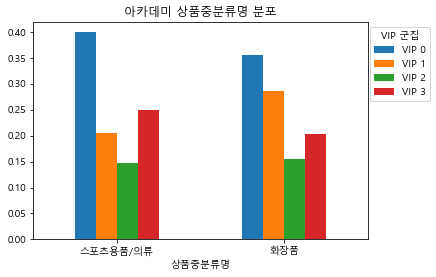

In [62]:
# 아카데미 상품중분류명을 많이 구매함
buy = pd.pivot_table(VIP.query("상품중분류명 in ['스포츠용품/의류', '화장품']"), 
                     index='segment', columns='상품중분류명', values='구매금액', aggfunc=sum, fill_value=0, margins=True)
buy = buy.div(buy.loc["All"])

buy.T.iloc[:-1, :-1].plot.bar(figsize=(6, 4), title="아카데미 상품중분류명 분포", rot=0)
plt.legend(title="VIP 군집", bbox_to_anchor=(1.2, 1))
plt.show()

### *`VIP 1`*
구매빈도를 늘려야하는 고객군집
- 고가상품구매율과 일별구매액을 파악하여 고가상품에 대한 마케팅을 활용한다.

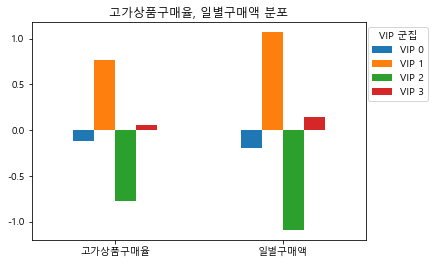

In [63]:
# 고가상품을 많이 구매함
feature_vip[['segment', '고가상품구매율', '일별구매액']].groupby('segment').mean().T\
.plot.bar(title='고가상품구매율, 일별구매액 분포', rot=0)
plt.legend(title="VIP 군집", bbox_to_anchor=(1.2, 1))
plt.show()

### *`VIP 2`*
구매금액을 늘려야 하는 고객군집
- 내점일자와 총구매액, 평균단가를 파악하여 고객집단이 주로 구매한 상품중분류명을 분석한다.
- VIP 데이터로 파악한 거래지역과 구매지역 동일여부에 따른 구매금액 상관관계를 활용하여
  <br>동지역 정도를 파악하고 마케팅 방안을 세운다.

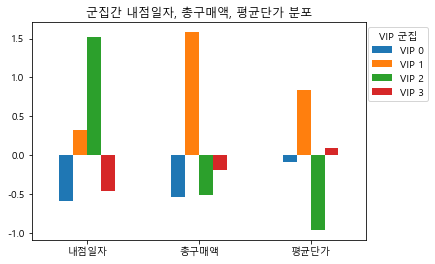

In [64]:
# 낮은 단가 상품을 주로 구매함
feature_vip[['segment', '내점일자', '총구매액', '평균단가']].groupby('segment').mean().T\
.plot.bar(title='군집간 내점일자, 총구매액, 평균단가 분포', rot=0)
plt.legend(title="VIP 군집", bbox_to_anchor=(1.2, 1))
plt.show()

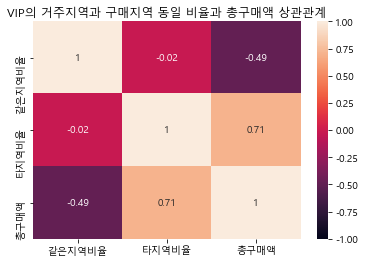

In [65]:
# 다른지역에서 구매할 경우 높은 양의 상관관계를 가짐
area = pd.concat([VIP.query('거주지역==구매지역').groupby('segment')['ID'].agg([('같은지역', pd.Series.nunique)]),
                  VIP.query('거주지역!=구매지역').groupby('segment')['ID'].agg([('타지역', pd.Series.nunique)])], axis=1)
area['고객수']=VIP.groupby('segment')['ID'].nunique()
area['같은지역비율'] = area['같은지역']/area['고객수']
area['타지역비율'] = area['타지역']/area['고객수']
area['총구매액'] = VIP.groupby('segment')['구매금액'].sum()

sns.heatmap(area.iloc[:, -3:].corr(), vmin=-1, vmax=1, annot=True)
plt.title('VIP의 거주지역과 구매지역 동일 비율과 총구매액 상관관계')
plt.show()

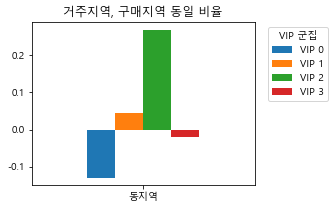

In [66]:
# 구매금액이 적은 것에 동지역 비율이 높은 것이 연관되어 있음 
feature_vip[['segment', '동지역']].groupby('segment').mean().T.plot.bar(rot=0, title='거주지역, 구매지역 동일 비율',
                                                                        figsize=(4, 3))
plt.legend(title="VIP 군집", bbox_to_anchor=(1.35, 1))
plt.show()

### *`VIP 3`*
최근에 구매가 적게 이루어진 고객집단
- 1+1 행사상품 feature로 1+1 행사 상품에 대한 관심도를 파악하여 백화점에 관심도를 높이는 마케팅을 추진한다.

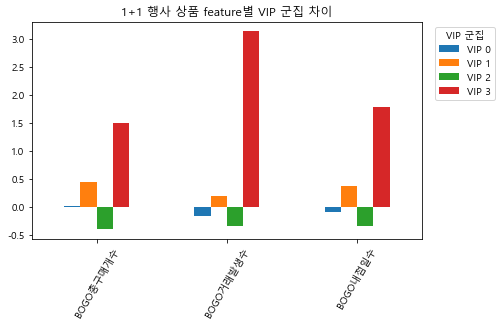

In [67]:
# 1+1 행사상품을 많이 구매함
feature_vip.loc[:, ['segment', 'BOGO총구매개수', 'BOGO거래발생수', 'BOGO내점일수']]\
.groupby('segment').mean().T.plot.bar(legend=False, figsize=(7, 4), rot=60, sharey=True)
plt.title("1+1 행사 상품 feature별 VIP 군집 차이")
plt.legend(title="VIP 군집", bbox_to_anchor=(1.2, 1))
plt.show()

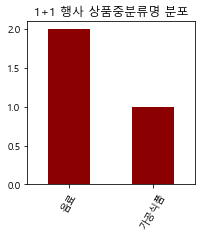

In [68]:
# 1+1 주구매 상품중분류명
id3 = vip.query('segment==3').ID
Bogo.query('ID in @id3').상품중분류명.value_counts().plot.bar(title="1+1 행사 상품중분류명 분포", rot=60, color='darkred',
                                                              figsize=(3, 3))
plt.show()

### ▶ Normal
&#160;&#160;&#160; Normal 0는 최근에 구매한 고객이며 구매빈도와 구매금액이 비교적 낮은 고객이다.
<br>&#160;&#160;&#160; Normal 1은 다른 군집에 비해 최근에 구매가 많이 일어나지 않았으며 구매빈도와 구매금액이 적은 고객들이다.
<br>&#160;&#160;&#160; Normal 2는 최근에 구매가 이루어졌으나 구매빈도와 구매금액이 낮은 고객이다.

In [69]:
# Normal RFM DataFrame
df_X_normal = pd.DataFrame(X_normal, columns=['Recency', 'Frequency', 'Monetary'])
df_X_normal = pd.concat([df_X_normal, normal.reset_index().segment], axis=1)
df_X_normal.segment = 'Normal '+df_X_normal.segment.astype('str')

<Figure size 432x288 with 0 Axes>

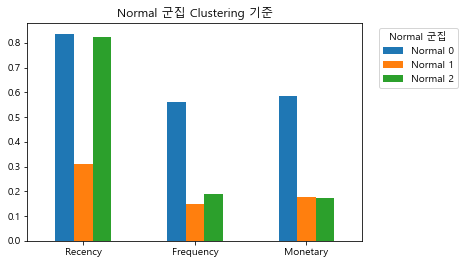

In [70]:
plt.tight_layout(h_pad=5)
df_X_normal.groupby('segment').mean().T.plot.bar(legend=False, figsize=(6, 4), rot=0, sharey=True)
plt.title("Normal 군집 Clustering 기준")
plt.legend(title="Normal 군집", bbox_to_anchor=(1.3, 1))
plt.show()

In [71]:
# Normal feature
normal_feature = feature.query('ID in @normal.ID')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normal_feature_data = scaler.fit_transform(normal_feature.iloc[:, 1:]) 
feature_norm = pd.DataFrame(normal_feature_data, columns=normal_feature.columns[1:])
feature_norm = normal.reset_index()[['ID', 'segment']].merge(pd.concat([normal_feature.reset_index()['ID'], feature_norm], axis=1))
feature_norm['segment'] = 'Normal '+ feature_norm['segment'].astype('str')

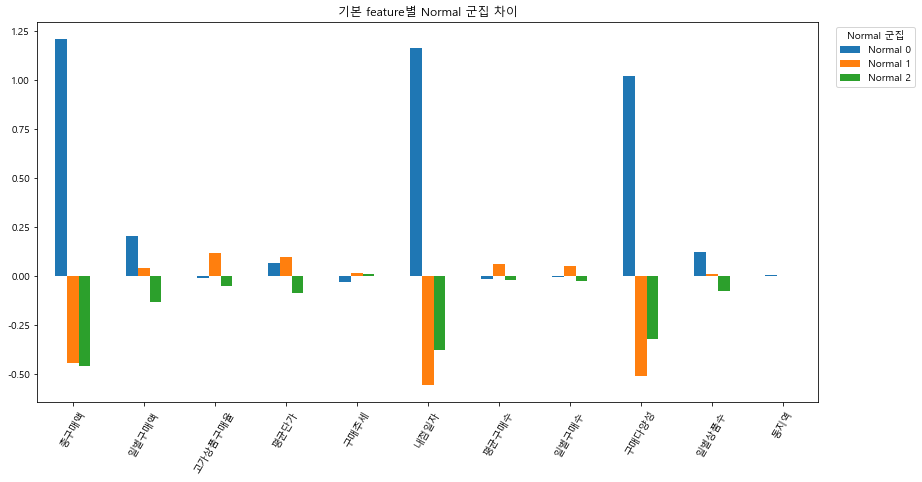

In [72]:
feature_norm.iloc[:, 1:-4].groupby('segment').mean().T.plot.bar(figsize=(14, 7), rot=60, sharey=True)
plt.title("기본 feature별 Normal 군집 차이")
plt.legend(title="Normal 군집", bbox_to_anchor=(1.13, 1))
plt.show()

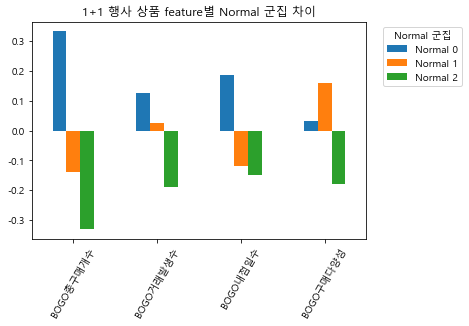

In [73]:
feature_norm.loc[:, ['segment', 'BOGO총구매개수', 'BOGO거래발생수', 'BOGO내점일수', 'BOGO구매다양성' ]]\
.groupby('segment').mean().T.plot.bar(legend=False, figsize=(6, 4), rot=60, sharey=True)
plt.title("1+1 행사 상품 feature별 Normal 군집 차이")
plt.legend(title="Normal 군집", bbox_to_anchor=(1.3, 1))
plt.show()

In [74]:
# Norm 데이터
Norm = df.query('ID in @normal.ID').reset_index().iloc[:, 1:]
Norm = Norm.merge(normal, on='ID')
Norm.segment = 'Normal '+Norm.segment.astype('str')

### *`Normal 0`*
구매빈도를 늘려야 하는 고객집단
- VIP와 동지역을 비교하여 구매지역의 편의에 관하여 분석한다.
- 여가활동을 공유할 집단을 만드는 데 중개역할을 맡는 것을 마케팅으로 활용할 수 있다. 
- 1+1 행사상품 feature로 1+1 행사 상품에 대한 관심도를 파악하여 백화점에 관심도를 높이는 마케팅을 추진한다.

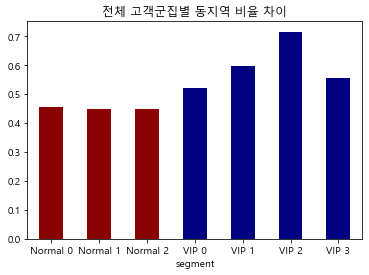

In [75]:
# 타 고객집단에 비해 동지역 비율이 낮음
same_erea = pd.concat([VIP[['ID','segment','동지역']], Norm[['ID','segment','동지역']]], axis =0)

same_erea.groupby('segment')['동지역'].mean().plot.bar(legend=False, color=['darkred']*3+['navy']*4,
                                                       title="전체 고객군집별 동지역 비율 차이", rot=0)
plt.show()

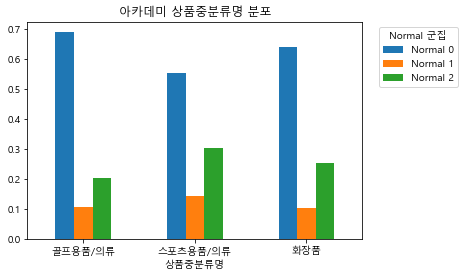

In [76]:
# 아카데미 상품중분류명을 많이 구매함
buy = pd.pivot_table(Norm.query("상품중분류명 in ['스포츠용품/의류', '골프용품/의류', '화장품']"), 
                     index='segment', columns='상품중분류명', values='구매금액', aggfunc=sum, fill_value=0, margins=True)
buy = buy.div(buy.loc["All"])

buy.T.iloc[:-1, :-1].plot.bar(figsize=(6, 4), title="아카데미 상품중분류명 분포", rot=0)
plt.legend(title="Normal 군집", bbox_to_anchor=(1.3, 1))
plt.show()

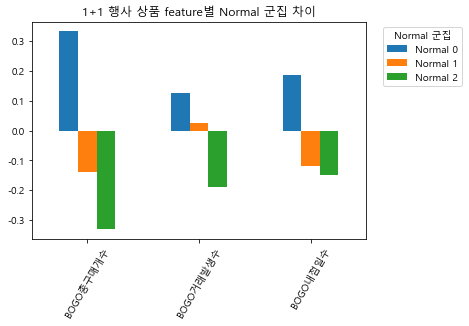

In [77]:
# 1+1 행사상품을 많이 구매함
feature_norm.loc[:, ['segment', 'BOGO총구매개수', 'BOGO거래발생수', 'BOGO내점일수']]\
.groupby('segment').mean().T.plot.bar(legend=False, figsize=(6, 4), rot=60, sharey=True)
plt.title("1+1 행사 상품 feature별 Normal 군집 차이")
plt.legend(title="Normal 군집", bbox_to_anchor=(1.3, 1))
plt.show()

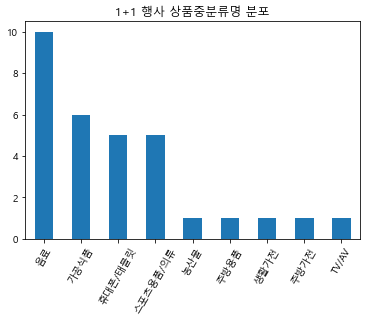

In [78]:
# 1+1 주구매 상품중분류명
id0 = normal.query('segment==0').ID
Bogo.query('ID in @id0').상품중분류명.value_counts().plot.bar(title="1+1 행사 상품중분류명 분포", rot=60)
plt.show()

### *`Normal 1`*
최근에 구매가 이루어지지 않아 백화점 관심도를 높여야 하는 고객군집
- 일별구매액과 고가상품구매율을 파악하여 구매가 발생하지 않은 12월에 구매가 발생하게 한다.

In [79]:
# 월별 구매고객수
month = pd.crosstab(Norm.drop_duplicates(['ID', '구매일자']).segment, Norm.drop_duplicates(['ID', '구매일자']).구매월, 
                    margins=True)
month = month.div(month['All'], axis=0)

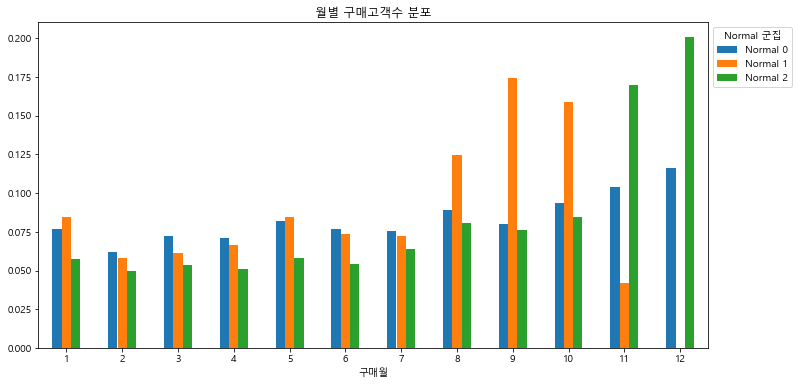

In [80]:
month.iloc[:-1, :-1].T.plot.bar(rot=0, title="월별 구매고객수 분포", figsize=(12, 6))
plt.legend(title="Normal 군집", bbox_to_anchor=(1, 1))
plt.show()

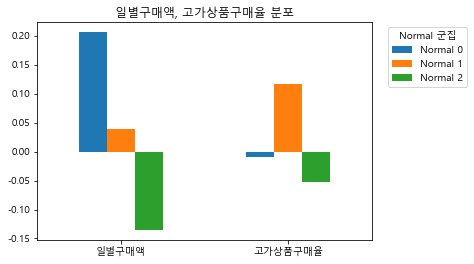

In [81]:
# 일별 구매액은 높지 않으나 고가상품구매율이 높은 것으로 보아 내점 시 고가상품 구매가 많이 이루어짐
feature_norm[['segment', '일별구매액', '고가상품구매율']].groupby('segment').mean().T.plot.bar(rot=0)
plt.title("일별구매액, 고가상품구매율 분포")
plt.legend(title="Normal 군집", bbox_to_anchor=(1.3, 1))
plt.show()

### *`Normal 2`*
구매빈도와 구매금액 모두를 올려야 하는 고객집단
- 월별 구매고객수와 월별 구매금액으로 그린 scatterplot을 파악하여 특정월의 구매금액이 모두 높았던 상품중분류명으로 마케팅을 진행한다.

In [82]:
# 월별 구매한 고객수와 총구매금액
scatter = Norm.drop_duplicates(['ID', '구매일자']).groupby(['segment', '구매월'])['ID'].agg([('월별구매고객수', 'size')])
scatter['월별총구매액'] = Norm.groupby(['segment', '구매월'])['구매금액'].sum()

In [83]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scatter_data = scaler.fit_transform(scatter) 
scatter_scaler = pd.DataFrame(scatter_data, columns=['월별구매고객수', '월별총구매액'])
scatter_scaler = scatter_scaler.set_index(scatter.index)

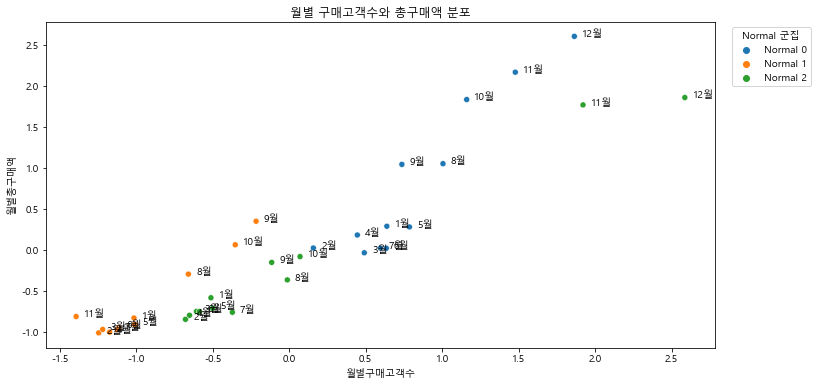

In [84]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scatter_scaler, x='월별구매고객수', y='월별총구매액', hue=scatter_scaler.index.get_level_values(0))
for i in range(scatter_scaler.shape[0]):
    plt.text(scatter_scaler.월별구매고객수.iloc[i]+0.05, scatter_scaler.월별총구매액.iloc[i], 
             str(scatter_scaler.index.get_level_values(1)[i])+'월')
plt.title("월별 구매고객수와 총구매액 분포")
plt.legend(title="Normal 군집", bbox_to_anchor=(1.15, 1))
plt.show()
plt.show()

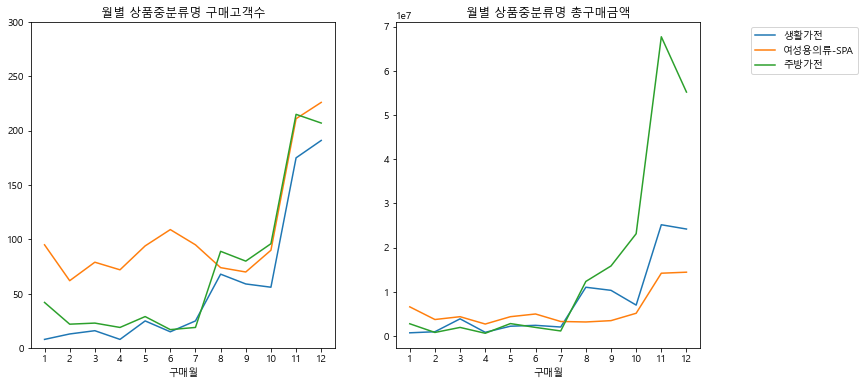

In [85]:
# 월별 상품중분류명
high = ['주방가전', '생활가전', '여성용의류-SPA']
month_tv = pd.pivot_table(Norm.query('segment=="Normal 2" and 상품중분류명 in @high'), 
                          index='구매월', columns='상품중분류명', values='ID', aggfunc='size', fill_value=0)

month_tp = pd.pivot_table(Norm.query('segment=="Normal 2" and 상품중분류명 in @high'), 
                          index='구매월', columns='상품중분류명', values='구매금액', aggfunc=sum, fill_value=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
month_tv.plot(title="월별 상품중분류명 구매고객수", ax=ax[0], legend=False)
month_tp.plot(title="월별 상품중분류명 총구매금액", ax=ax[1])
ax[0].set_ylim(0, 300)
ax[0].set_xticks(range(1, 13))
plt.legend(bbox_to_anchor=(1.15, 1))
plt.show()